### Comparing the models Performance

#### Import required  libraries
* install the below packages if missing

```bash
    %pip install pandas numpy tensorflow scikit-learn plotly matplotlib
```

**NEW LSTM MODEL**

Starting stock price prediction system...
Stock symbol: NFLX
Data path: /Users/sunithakosireddy/Downloads/data
Processing data for NFLX...

Using cutoff date: 2024-12-09 14:59:49.950564
Processing data for NFLX...

Using cutoff date: 2024-12-09 14:59:49.950616

Reading data files...

Processing data...

Stock data range: 2002-05-31 00:00:00 to 2024-12-06 00:00:00

Earnings data range: 2002-08-28 00:00:00 to 2024-10-17 00:00:00

Insider data range: 2016-03-01 00:00:00 to 2024-11-20 00:00:00

Saving processed data...

Processed Features Preview:

Feature DataFrame Head:
             price   volume  surprise  surprise_pct  insider_volume  price_change  volume_change  price_ma5  volume_ma5  volatility
Date                                                                                                                               
2002-05-31  1.0764  2284700       0.0           0.0             0.0      0.000000       0.000000      0.000         0.0         0.0
2002-06-07  1.1186   818800  

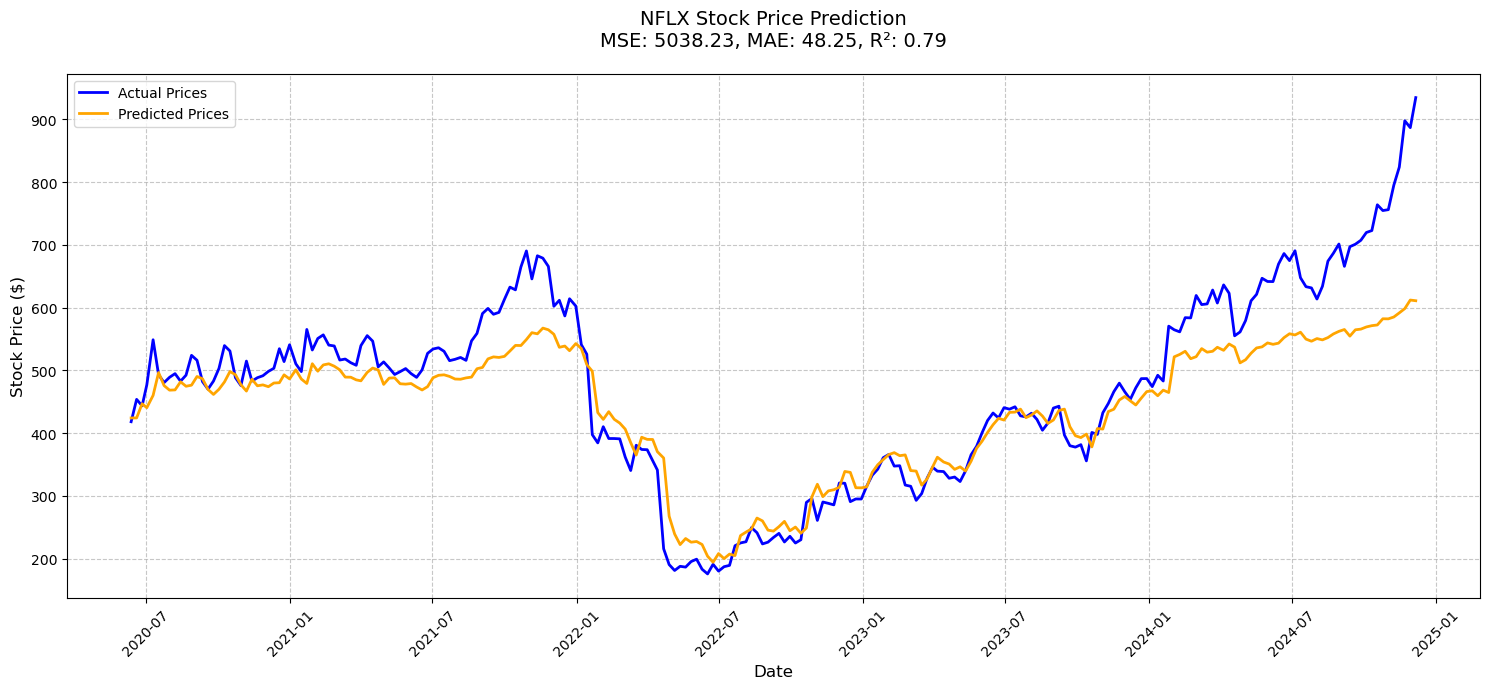


Training completed successfully!

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 3, 200)         │        88,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,997 (1.61 MB)

 Trainable params: 140,665 (549.47 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 281,332 (1.07 MB)


Best hyperparameters used:
lstm_units: 100
lstm_units2: 50
dense_units: 32
dropout1: 0.2
dropout2: 0.1
regularization: 0.001
learning_rate: 0.001
batch_size: 32
epochs: 100
patience: 15

Features used in the model:
- price
- volume
- surprise
- surprise_pct
- insider_volume
- price_change
- volume_change
- price_ma5
- volume_ma5
- volatility

Final Model Performance:
Mean Squared Error: 5038.23
Mean Absolute Error: 48.25
R² Score: 0.79



Would you like to save the results? (y/n):  y



Results saved to: results_NFLX_20241209_150212


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
import keras.backend as K
import tempfile
import os
import tensorflow as tf

class Normalizer:
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=0, keepdims=True)
        self.sd = np.std(x, axis=0, keepdims=True)
        self.sd[self.sd == 0] = 1
        return (x - self.mu) / self.sd

    def inverse_transform(self, x):
        return (x * self.sd) + self.mu

def process_stock_data(df_stock, cutoff_date=None):
    df_stock['Date'] = pd.to_datetime(df_stock['Date'])
    df_stock['Week'] = df_stock['Date'].dt.to_period('W')
    
    if cutoff_date:
        df_stock = df_stock[df_stock['Date'] <= cutoff_date]
    
    df_stock.sort_values('Date', inplace=True)
    print(f"\nStock data range: {df_stock['Date'].min()} to {df_stock['Date'].max()}")
    return df_stock

def process_earnings_data(df_earnings, cutoff_date=None):
    df_earnings['fiscalDateEnding'] = pd.to_datetime(df_earnings['fiscalDateEnding'])
    df_earnings['reportedDate'] = pd.to_datetime(df_earnings['reportedDate'])
    df_earnings['Week'] = df_earnings['reportedDate'].dt.to_period('W')
    
    if cutoff_date:
        df_earnings = df_earnings[df_earnings['reportedDate'] <= cutoff_date]
    
    weekly_earnings = df_earnings.sort_values('reportedDate').groupby('Week').last().reset_index()
    print(f"\nEarnings data range: {df_earnings['reportedDate'].min()} to {df_earnings['reportedDate'].max()}")
    return weekly_earnings

def process_insider_data(df_insider, cutoff_date=None):
    df_insider['transaction_date'] = pd.to_datetime(df_insider['transaction_date'])
    df_insider['Week'] = df_insider['transaction_date'].dt.to_period('W')
    
    if cutoff_date:
        df_insider = df_insider[df_insider['transaction_date'] <= cutoff_date]
    
    weekly_insider = df_insider.groupby(['Week', 'acquisition_or_disposal']).agg({
        'shares': 'sum',
        'share_price': 'mean'
    }).unstack(fill_value=0)
    
    weekly_insider.columns = [f"{col[0]}_{col[1]}" for col in weekly_insider.columns]
    
    if 'shares_A' not in weekly_insider.columns:
        weekly_insider['shares_A'] = 0
    if 'shares_D' not in weekly_insider.columns:
        weekly_insider['shares_D'] = 0
    
    weekly_insider['net_volume'] = weekly_insider['shares_A'] - weekly_insider['shares_D']
    weekly_insider = weekly_insider.reset_index()
    
    print(f"\nInsider data range: {df_insider['transaction_date'].min()} to {df_insider['transaction_date'].max()}")
    return weekly_insider

def combine_data(df_stock, weekly_earnings, weekly_insider):
    combined_df = df_stock.copy()
    
    combined_df = pd.merge(
        combined_df,
        weekly_earnings[['Week', 'surprise', 'surprisePercentage']],
        on='Week',
        how='left'
    )
    
    combined_df = pd.merge(
        combined_df,
        weekly_insider[['Week', 'net_volume']],
        on='Week',
        how='left'
    )
    
    combined_df = combined_df.set_index('Date')
    combined_df = combined_df.groupby('Week').ffill()
    combined_df = combined_df.fillna(0)
    
    return combined_df

def create_features(combined_df):
    features_df = pd.DataFrame({
        'price': combined_df['Adjusted Close'],
        'volume': combined_df['Volume'],
        'surprise': combined_df['surprise'],
        'surprise_pct': combined_df['surprisePercentage'],
        'insider_volume': combined_df['net_volume']
    })
    
    features_df['price_change'] = features_df['price'].pct_change()
    features_df['volume_change'] = features_df['volume'].pct_change()
    
    features_df['price_ma5'] = features_df['price'].rolling(window=5).mean()
    features_df['volume_ma5'] = features_df['volume'].rolling(window=5).mean()
    features_df['volatility'] = features_df['price_change'].rolling(window=5).std()
    
    features_df = features_df.replace([np.inf, -np.inf], np.nan)
    features_df = features_df.ffill().fillna(0)
    
    return features_df

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

def build_tuned_model(input_shape, params):
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(params['lstm_units'], 
                          return_sequences=True,
                          kernel_regularizer=regularizers.l2(params['regularization']))),
        Dropout(params['dropout1']),
        LSTM(params['lstm_units2'],
             return_sequences=False,
             kernel_regularizer=regularizers.l2(params['regularization'])),
        Dropout(params['dropout2']),
        Dense(params['dense_units'], activation='relu',
              kernel_regularizer=regularizers.l2(params['regularization'])),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')
    return model

def objective_function(params, X_train, y_train, X_val, y_val):
    K.clear_session()
    model = build_tuned_model((X_train.shape[1], X_train.shape[2]), params)
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=params['patience'],
        restore_best_weights=True
    )
    
    try:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            callbacks=[early_stopping],
            verbose=0
        )
        
        best_val_loss = min(history.history['val_loss'])
        
    except Exception as e:
        print(f"Error during training: {str(e)}")
        best_val_loss = float('inf')
    
    return best_val_loss, model

def hyperparameter_tuning(X, y, n_splits=5):
    param_combinations = [
        {
            'lstm_units': 100,
            'lstm_units2': 50,
            'dense_units': 32,
            'dropout1': 0.2,
            'dropout2': 0.1,
            'regularization': 0.001,
            'learning_rate': 0.001,
            'batch_size': 32,
            'epochs': 100,
            'patience': 15
        },
        {
            'lstm_units': 150,
            'lstm_units2': 75,
            'dense_units': 64,
            'dropout1': 0.3,
            'dropout2': 0.2,
            'regularization': 0.01,
            'learning_rate': 0.001,
            'batch_size': 32,
            'epochs': 100,
            'patience': 15
        },
        {
            'lstm_units': 50,
            'lstm_units2': 25,
            'dense_units': 32,
            'dropout1': 0.1,
            'dropout2': 0.1,
            'regularization': 0.001,
            'learning_rate': 0.01,
            'batch_size': 64,
            'epochs': 100,
            'patience': 15
        },
        {
            'lstm_units': 128,
            'lstm_units2': 64,
            'dense_units': 48,
            'dropout1': 0.25,
            'dropout2': 0.15,
            'regularization': 0.005,
            'learning_rate': 0.0005,
            'batch_size': 32,
            'epochs': 100,
            'patience': 15
        },
        {
            'lstm_units': 64,
            'lstm_units2': 32,
            'dense_units': 32,
            'dropout1': 0.2,
            'dropout2': 0.1,
            'regularization': 0.001,
            'learning_rate': 0.005,
            'batch_size': 64,
            'epochs': 100,
            'patience': 15
        }
    ]
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_score = float('inf')
    best_params = None
    best_model = None
    results = []
    
    print(f"Testing {len(param_combinations)} parameter combinations...")
    
    try:
        for i, params in enumerate(param_combinations):
            scores = []
            print(f"\nTesting combination {i+1}/{len(param_combinations)}")
            print("Parameters being tested:")
            for key, value in params.items():
                print(f"{key}: {value}")
            
            try:
                for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
                    print(f"Fold {fold+1}/{n_splits}")
                    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
                    y_train_cv, y_val_cv = y[train_idx], y[val_idx]
                    
                    score, model = objective_function(
                        params, X_train_cv, y_train_cv, X_val_cv, y_val_cv
                    )
                    
                    if score != float('inf'):
                        scores.append(score)
                
                if len(scores) > 0:
                    mean_score = np.mean(scores)
                    results.append((params, mean_score))
                    
                    print(f"Mean validation loss: {mean_score:.4f}")
                    
                    if mean_score < best_score:
                        best_score = mean_score
                        best_params = params
                        best_model = model
                        print("New best score found!")
                
            except Exception as e:
                print(f"Error during fold processing: {str(e)}")
                continue
        
        if not results:
            raise ValueError("No valid results obtained during hyperparameter tuning")
            
        results.sort(key=lambda x: x[1])
        
        print("\nResults for all configurations:")
        for i, (params, score) in enumerate(results):
            print(f"\nConfiguration {i+1}")
            print(f"Score: {score:.4f}")
            print("Parameters:")
            for key, value in params.items():
                print(f"{key}: {value}")
        
        return best_model, best_params
        
    except Exception as e:
        print(f"Error during hyperparameter tuning: {str(e)}")
        default_params = param_combinations[0]
        print("\nUsing default parameters due to tuning failure:")
        for param, value in default_params.items():
            print(f"{param}: {value}")
            
        model = build_tuned_model((X.shape[1], X.shape[2]), default_params)
        return model, default_params

def train_and_evaluate(stock, data_path, time_step=3, save_preprocessed_data=True):
    print(f"Processing data for {stock}...")
    
    cutoff_date = pd.Timestamp.now()
    print(f"\nUsing cutoff date: {cutoff_date}")

    print(f"Processing data for {stock}...")
    
    cutoff_date = pd.Timestamp.now()
    print(f"\nUsing cutoff date: {cutoff_date}")
    save_path="/Users/sunithakosireddy/Downloads/data"
    try:
        # Read data
        print("\nReading data files...")
        df_stock = pd.read_csv(f'{save_path}/{stock}_weekly_adjusted.csv')
        df_earnings = pd.read_csv(f'{save_path}/{stock}_earnings.csv')
        df_insider = pd.read_csv(f'{save_path}/{stock}_insider_transactions.csv')
        
        # Process data
        print("\nProcessing data...")
        df_stock = process_stock_data(df_stock, cutoff_date)
        weekly_earnings = process_earnings_data(df_earnings, cutoff_date)
        weekly_insider = process_insider_data(df_insider, cutoff_date)
        
        # Combine and create features
        combined_df = combine_data(df_stock, weekly_earnings, weekly_insider)
        features_df = create_features(combined_df)
        dates = combined_df.index
        
        # Optionally save the processed data
        if save_preprocessed_data:
            print("\nSaving processed data...")
            output_path = f"{save_path}/{stock}_processed_data"
            os.makedirs(output_path, exist_ok=True)
            #print preprocessed data
            print_processed_data(features_df, combined_df, output_path)
            print(f"Processed data saved to {output_path}")
        
        # Scale and prepare sequences
        normalizer = Normalizer()
        features_scaled = normalizer.fit_transform(features_df.values)
        X, y = create_dataset(features_scaled, time_step)
        
        
        print("\nStarting hyperparameter tuning...")
        best_model, best_params = hyperparameter_tuning(X, y)
        
        # Save preprocessed data if requested
        if save_preprocessed_data:
            print("\nSaving preprocessed training and test datasets...")
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
            
            # Save features (X_train, X_test) as CSV
            np.savetxt(f"{save_path}/{stock}_X_train.csv", X_train.reshape(X_train.shape[0], -1), delimiter=",")
            np.savetxt(f"{save_path}/{stock}_X_test.csv", X_test.reshape(X_test.shape[0], -1), delimiter=",")
            
            # Save targets (y_train, y_test) as CSV
            np.savetxt(f"{save_path}/{stock}_y_train.csv", y_train, delimiter=",")
            np.savetxt(f"{save_path}/{stock}_y_test.csv", y_test, delimiter=",")
            print(f"Preprocessed data saved as {save_path}/{stock}_X_train.csv, {save_path}/{stock}_X_test.csv, {save_path}/{stock}_y_train.csv, {stock}_y_test.csv")
        
        # Final evaluation
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        test_dates = dates[-(len(y_test)):]
        
        final_model = build_tuned_model((X_train.shape[1], X_train.shape[2]), best_params)
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=best_params['patience'],
            restore_best_weights=True
        )
        
        history = final_model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=best_params['epochs'],
            batch_size=best_params['batch_size'],
            callbacks=[early_stop],
            verbose=1
        )
        
        # Generate predictions
        predictions = final_model.predict(X_test)
        
        pred_shape = predictions.shape[0]
        feature_count = features_df.shape[1]
        
        predictions_inv = normalizer.inverse_transform(
            np.column_stack((predictions, np.zeros((pred_shape, feature_count - 1))))
        )[:, 0]
        y_test_inv = normalizer.inverse_transform(
            np.column_stack((y_test.reshape(-1, 1), np.zeros((pred_shape, feature_count - 1))))
        )[:, 0]
        
        # Calculate metrics
        mse = mean_squared_error(y_test_inv, predictions_inv)
        mae = mean_absolute_error(y_test_inv, predictions_inv)
        r2 = r2_score(y_test_inv, predictions_inv)
        
        print("\nModel Performance:")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"Mean Absolute Error: {mae:.2f}")
        print(f"R² Score: {r2:.2f}")
        
        # Plot results with actual dates
        plt.figure(figsize=(15, 7))
        plt.plot(test_dates, y_test_inv, label="Actual Prices", color='blue', linewidth=2)
        plt.plot(test_dates, predictions_inv, label="Predicted Prices", color='orange', linewidth=2)
        
        plt.title(f"{stock} Stock Price Prediction\nMSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}", 
                  fontsize=14, pad=20)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Stock Price ($)", fontsize=12)
        plt.legend(fontsize=10)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Return results dictionary with all relevant information
        return final_model, {
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'best_params': best_params,
            'test_dates': test_dates,
            'actual_values': y_test_inv,
            'predicted_values': predictions_inv,
            'history': history.history,
            'features': features_df.columns.tolist(),
            'normalizer': normalizer  # Save for future predictions
        }
        
    except Exception as e:
        print(f"Error during processing: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None
        


def print_processed_data(features_df, combined_df, output_path=None):
    """Print and optionally save preprocessed data"""
    print("\nProcessed Features Preview:")
    print("\nFeature DataFrame Head:")
    print(features_df.head().to_string())
    
    print("\nFeature DataFrame Info:")
    print("\nShape:", features_df.shape)
    print("\nColumns:", features_df.columns.tolist())
    
    print("\nFeature Statistics:")
    print(features_df.describe().to_string())
    
    print("\nCombined Data Preview:")
    print("\nCombined DataFrame Head:")
    print(combined_df.head().to_string())
    #print pre-processed data into output file
    features_df.to_csv(f"/Users/sunithakosireddy/Downloads/processed_features.csv")
    combined_df.to_csv(f"/Users/sunithakosireddy/Downloads/processed_combined_data.csv")
  #  if output_path:
  #      # Save to CSV
  #      features_df.to_csv(f"/Users/sunithakosireddy/Downloads/processed_features.csv")
  #      combined_df.to_csv(f"/Users/sunithakosireddy/Downloads/processed_combined_data.csv")
   #     print(f"\nData saved to: {output_path}")

if __name__ == "__main__":
    # Configuration
    stock = 'NFLX'
    data_path = '/Users/sunithakosireddy/Downloads/data'  # Update with your actual data path
    
    # Set random seeds for reproducibility
    np.random.seed(16)
    tf.random.set_seed(16)
    
    print("Starting stock price prediction system...")
    print(f"Stock symbol: {stock}")
    print(f"Data path: {data_path}")
    
    # Run the model
    model, results = train_and_evaluate(stock, data_path)
    # Print processed data
  #  print_processed_data(features_df, combined_df)
    if results is not None:
        print("\nTraining completed successfully!")
        
        # Print model architecture
        print("\nModel Architecture:")
        model.summary()
        
        # Print hyperparameters
        print("\nBest hyperparameters used:")
        for param, value in results['best_params'].items():
            print(f"{param}: {value}")
        
        # Print features
        print("\nFeatures used in the model:")
        for feature in results['features']:
            print(f"- {feature}")
        
        # Print performance metrics
        print("\nFinal Model Performance:")
        print(f"Mean Squared Error: {results['mse']:.2f}")
        print(f"Mean Absolute Error: {results['mae']:.2f}")
        print(f"R² Score: {results['r2']:.2f}")
        
        # Save results if desired
        save_results = input("\nWould you like to save the results? (y/n): ")
        if save_results.lower() == 'y':
            try:
                # Create directory with timestamp
                save_path = f"results_{stock}_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}"
                os.makedirs(save_path, exist_ok=True)
                
                # Save model
                model.save(f"{save_path}/model.keras")
                
                # Save predictions
                pd.DataFrame({
                    'Date': results['test_dates'],
                    'Actual': results['actual_values'],
                    'Predicted': results['predicted_values']
                }).to_csv(f"{save_path}/predictions.csv", index=False)
                
                # Save metrics and parameters
                with open(f"{save_path}/results.txt", 'w') as f:
                    f.write("Model Performance:\n")
                    f.write(f"MSE: {results['mse']:.2f}\n")
                    f.write(f"MAE: {results['mae']:.2f}\n")
                    f.write(f"R²: {results['r2']:.2f}\n\n")
                    
                    f.write("Best Parameters:\n")
                    for param, value in results['best_params'].items():
                        f.write(f"{param}: {value}\n")
                    
                    f.write("\nFeatures Used:\n")
                    for feature in results['features']:
                        f.write(f"- {feature}\n")
                
                print(f"\nResults saved to: {save_path}")
                
            except Exception as e:
                print(f"Error saving results: {str(e)}")
    else:
        print("\nTraining failed. Please check the error messages above.")
     